In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/Thesis

Mounted at /content/drive
/content/drive/MyDrive/Thesis


In [1]:
# %%pycodestyle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve, precision_score
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Data Preparation

## Load DataFrame


In [2]:
# %%pycodestyle
df = pd.read_csv('creditcard.csv')
df.head()
# Time: Number of seconds elapsed between this transaction and the first transaction in the dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

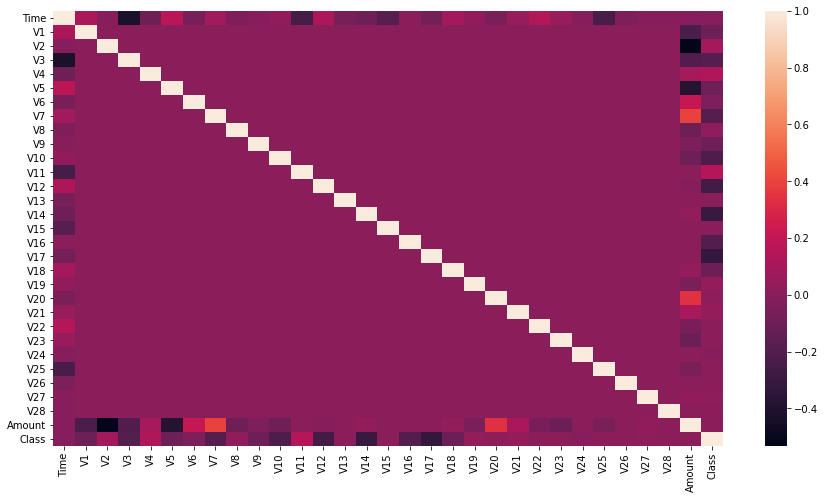

In [3]:
# %%pycodestyle
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(15, 8))
sns.heatmap(df.corr())

[Text(0, 0, 'Genuine (0)'), Text(1, 0, 'Fraud (1)')]

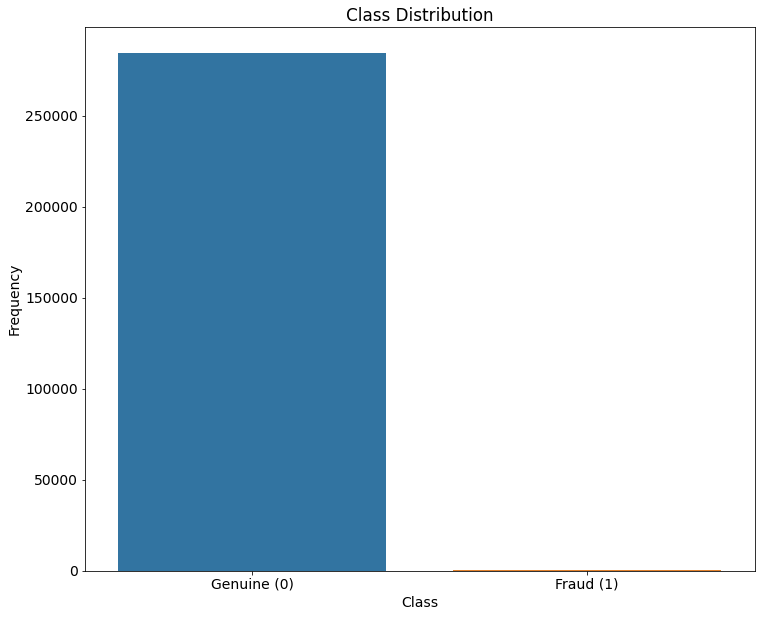

In [4]:
# %%pycodestyle
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.countplot(data=df, x='Class')
ax.set_title('Class Distribution')
ax.set(xlabel="Class", ylabel = "Frequency")
ax.set_xticklabels(['Genuine (0)', 'Fraud (1)'])

## Normalization ('Amount')


In [5]:
scaler = StandardScaler()
df[['Amount']] = scaler.fit_transform(df[['Amount']].values)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## Split X, y

In [6]:
# %%pycodestyle
y = df[['Class']]
X = df.drop(['Class'], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

## Random Oversampling

In [8]:
oversampler = RandomOverSampler(sampling_strategy=0.1, random_state=14)
X_over_1, y_over_1 = oversampler.fit_resample(X_train,y_train)
y_over_1 = np.ravel(y_over_1)
print(Counter(y_over_1))

oversampler = RandomOverSampler(sampling_strategy=0.2, random_state=14)
X_over_2, y_over_2 = oversampler.fit_resample(X_train,y_train)
y_over_2 = np.ravel(y_over_2)
print(Counter(y_over_2))

oversampler = RandomOverSampler(sampling_strategy=0.3, random_state=14)
X_over_3, y_over_3 = oversampler.fit_resample(X_train,y_train)
y_over_3 = np.ravel(y_over_3)
print(Counter(y_over_3))

oversampler = RandomOverSampler(sampling_strategy=0.4, random_state=14)
X_over_4, y_over_4 = oversampler.fit_resample(X_train,y_train)
y_over_4 = np.ravel(y_over_4)
print(Counter(y_over_4))

oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=14)
X_over_5, y_over_5 = oversampler.fit_resample(X_train,y_train)
y_over_5 = np.ravel(y_over_5)
print(Counter(y_over_5))

oversampler = RandomOverSampler(sampling_strategy=0.6, random_state=14)
X_over_6, y_over_6 = oversampler.fit_resample(X_train,y_train)
y_over_6 = np.ravel(y_over_6)
print(Counter(y_over_6))

oversampler = RandomOverSampler(sampling_strategy=0.7, random_state=14)
X_over_7, y_over_7 = oversampler.fit_resample(X_train,y_train)
y_over_7 = np.ravel(y_over_7)
print(Counter(y_over_7))

oversampler = RandomOverSampler(sampling_strategy=0.7, random_state=14)
X_over_7, y_over_7 = oversampler.fit_resample(X_train,y_train)
y_over_7 = np.ravel(y_over_7)
print(Counter(y_over_7))

oversampler = RandomOverSampler(sampling_strategy=0.8, random_state=14)
X_over_8, y_over_8 = oversampler.fit_resample(X_train,y_train)
y_over_8 = np.ravel(y_over_8)
print(Counter(y_over_8))

oversampler = RandomOverSampler(sampling_strategy=0.9, random_state=14)
X_over_9, y_over_9 = oversampler.fit_resample(X_train,y_train)
y_over_9 = np.ravel(y_over_9)
print(Counter(y_over_9))

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=14)
X_over, y_over = oversampler.fit_resample(X_train,y_train)
y_over = np.ravel(y_over)
print(Counter(y_over))

Counter({0: 199013, 1: 19901})
Counter({0: 199013, 1: 39802})
Counter({0: 199013, 1: 59703})
Counter({0: 199013, 1: 79605})
Counter({0: 199013, 1: 99506})
Counter({0: 199013, 1: 119407})
Counter({0: 199013, 1: 139309})
Counter({0: 199013, 1: 139309})
Counter({0: 199013, 1: 159210})
Counter({0: 199013, 1: 179111})
Counter({0: 199013, 1: 199013})


## Random Undersampling

In [9]:
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=14)
X_under_1, y_under_1 = undersampler.fit_resample(X_train,y_train)
y_under_1 = np.ravel(y_under_1)
print(Counter(y_under_1))

undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=14)
X_under_2, y_under_2 = undersampler.fit_resample(X_train,y_train)
y_under_2 = np.ravel(y_under_2)
print(Counter(y_under_2))

undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=14)
X_under_3, y_under_3 = undersampler.fit_resample(X_train,y_train)
y_under_3 = np.ravel(y_under_3)
print(Counter(y_under_3))

undersampler = RandomUnderSampler(sampling_strategy=0.4, random_state=14)
X_under_4, y_under_4 = undersampler.fit_resample(X_train,y_train)
y_under_4 = np.ravel(y_under_4)
print(Counter(y_under_4))

undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=14)
X_under_5, y_under_5 = undersampler.fit_resample(X_train,y_train)
y_under_5 = np.ravel(y_under_5)
print(Counter(y_under_5))

undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=14)
X_under_6, y_under_6 = undersampler.fit_resample(X_train,y_train)
y_under_6 = np.ravel(y_under_6)
print(Counter(y_under_6))

undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=14)
X_under_7, y_under_7 = undersampler.fit_resample(X_train,y_train)
y_under_7 = np.ravel(y_under_7)
print(Counter(y_under_7))

undersampler = RandomUnderSampler(sampling_strategy=0.8, random_state=14)
X_under_8, y_under_8 = undersampler.fit_resample(X_train,y_train)
y_under_8 = np.ravel(y_under_8)
print(Counter(y_under_8))

undersampler = RandomUnderSampler(sampling_strategy=0.9, random_state=14)
X_under_9, y_under_9 = undersampler.fit_resample(X_train,y_train)
y_under_9 = np.ravel(y_under_9)
print(Counter(y_under_9))

undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=14)
X_under, y_under = undersampler.fit_resample(X_train,y_train)
y_under = np.ravel(y_under)
print(Counter(y_under))

Counter({0: 3510, 1: 351})
Counter({0: 1755, 1: 351})
Counter({0: 1170, 1: 351})
Counter({0: 877, 1: 351})
Counter({0: 702, 1: 351})
Counter({0: 585, 1: 351})
Counter({0: 501, 1: 351})
Counter({0: 438, 1: 351})
Counter({0: 390, 1: 351})
Counter({0: 351, 1: 351})


## SMOTE

In [13]:
smote = SMOTE(sampling_strategy=0.1,random_state=14)
X_smote_1, y_smote_1 = smote.fit_resample(X_train, y_train)
y_smote_1 = np.ravel(y_smote_1)
print(Counter(y_smote_1))

smote = SMOTE(sampling_strategy=0.2,random_state=14)
X_smote_2, y_smote_2 = smote.fit_resample(X_train, y_train)
y_smote_2 = np.ravel(y_smote_2)
print(Counter(y_smote_2))

smote = SMOTE(sampling_strategy=0.3,random_state=14)
X_smote_3, y_smote_3 = smote.fit_resample(X_train, y_train)
y_smote_3 = np.ravel(y_smote_3)
print(Counter(y_smote_3))

smote = SMOTE(sampling_strategy=0.4,random_state=14)
X_smote_4, y_smote_4 = smote.fit_resample(X_train, y_train)
y_smote_4 = np.ravel(y_smote_4)
print(Counter(y_smote_4))

smote = SMOTE(sampling_strategy=0.5,random_state=14)
X_smote_5, y_smote_5 = smote.fit_resample(X_train, y_train)
y_smote_5 = np.ravel(y_smote_5)
print(Counter(y_smote_5))

smote = SMOTE(sampling_strategy=0.6,random_state=14)
X_smote_6, y_smote_6 = smote.fit_resample(X_train, y_train)
y_smote_6 = np.ravel(y_smote_6)
print(Counter(y_smote_6))

smote = SMOTE(sampling_strategy=0.7,random_state=14)
X_smote_7, y_smote_7 = smote.fit_resample(X_train, y_train)
y_smote_7 = np.ravel(y_smote_7)
print(Counter(y_smote_7))

smote = SMOTE(sampling_strategy=0.8,random_state=14)
X_smote_8, y_smote_8 = smote.fit_resample(X_train, y_train)
y_smote_8 = np.ravel(y_smote_8)
print(Counter(y_smote_8))

smote = SMOTE(sampling_strategy=0.9,random_state=14)
X_smote_9, y_smote_9 = smote.fit_resample(X_train, y_train)
y_smote_9 = np.ravel(y_smote_9)
print(Counter(y_smote_9))

smote = SMOTE(sampling_strategy='minority',random_state=14)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote = np.ravel(y_smote)
print(Counter(y_smote))

Counter({0: 199013, 1: 19901})
Counter({0: 199013, 1: 39802})
Counter({0: 199013, 1: 59703})
Counter({0: 199013, 1: 79605})
Counter({0: 199013, 1: 99506})
Counter({0: 199013, 1: 119407})
Counter({0: 199013, 1: 139309})
Counter({0: 199013, 1: 159210})
Counter({0: 199013, 1: 179111})
Counter({0: 199013, 1: 199013})


## Tomek Links Removal

In [8]:
tomek = TomekLinks(sampling_strategy='majority')
X_tomek, y_tomek = tomek.fit_resample(X_train,y_train)
y_tomek = np.ravel(y_tomek)
Counter(y_tomek)

Counter({0: 198999, 1: 351})

## Hybrid

In [16]:
# Applying tomek after smote
X_hybrid, y_hybrid = tomek.fit_resample(X_smote_7, y_smote_7)
y_hybrid = np.ravel(y_hybrid)
Counter(y_hybrid)

Counter({0: 198760, 1: 139309})

# XGBoost with no Resampling


## Hyperparameters Tuning

### Subsample and Colsample

In [ ]:
XGB_PARAM={'subsample':[0.5,0.6,0.7,0.8]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)

In [ ]:
search.fit(X_train,np.ravel(y_train))

NameError: ignored

In [ ]:
best_subsample = search.best_params_['subsample']
print(best_subsample) #0.5

0.5
0.18257418583505539


In [ ]:
XGB_PARAM={'colsample_bytree':[0.5,0.6,0.7,0.8,0.9]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.5)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', re

In [ ]:
best_colsample = search.best_params_['colsample_bytree']
print(best_colsample) #0.9

0.9


### Max depth and alpha

In [ ]:
XGB_PARAM = {'max_depth':[3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.5, colsample_bytree=0.9)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 56.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=T

In [ ]:
best_depth = search.best_params_['max_depth']
print(best_depth) #8

8


In [ ]:
XGB_PARAM={'alpha':[0,0.0001,0.001,0.1]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.5, 
                        colsample_bytree=0.9,
                        max_depth=8)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 32.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, r

In [ ]:
best_alpha = search.best_params_['alpha']
print(best_alpha) #0.0001

0.0001


### Min child weight and gamma

In [ ]:
XGB_PARAM = {'min_child_weight':[1,2,3,4,5,6,7,8,9,10],
             'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.5, 
                        colsample_bytree=0.9,
                        max_depth=4,
                        alpha=0.0001)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(alpha=0.0001, base_score=None,
                                     booster=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=4, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsampl

In [ ]:
best_child_weight = search.best_params_['min_child_weight']
print(best_child_weight)# 1
best_gamma = search.best_params_['gamma']
print(best_gamma)# 0

1
0


### Estimators and learning rate


In [ ]:
XGB_PARAM = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False,
                        n_jobs=-1, 
                        verbosity=0,
                        learning_rate=0.1,
                        subsample=0.5, 
                        colsample_bytree=0.9,
                        max_depth=4,
                        alpha=0.0001,
                        min_child_weight=1,
                        gamma=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(alpha=0.0001, base_score=None,
                                     booster=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.5,


In [ ]:
best_estimator = search.best_params_['n_estimators']
print(best_estimator) #800

800


In [ ]:
XGB_PARAM = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False,
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5, 
                        colsample_bytree=0.9,
                        max_depth=4,
                        alpha=0.0001,
                        min_child_weight=1,
                        gamma=0,
                        n_estimators=800)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_train,np.ravel(y_train))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 79.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0.0001, base_score=0.5,
                                     booster='gbtree', colsample_bylevel=1,
                                     colsample_bynode=1,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=4,
                                     min_child_weight=1, missing=None,
                                     n_estimators=800, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
       

In [ ]:
best_learning_rate = search.best_params_['learning_rate']
print(best_learning_rate) #0.3

0.3


### Final Params

Params: subsample = 0.5, colsample = 0.9, max_depth = 4, alpha = 0.0001, min_child_weight=1,gamma=0, n_estimators=800, learning_rate=0.3

In [ ]:
xgb = xgb.XGBClassifier(use_label_encoder=False,
                        n_jobs=-1, 
                        verbosity=3,
                        learning_rate=0.3,
                        subsample=0.5, 
                        colsample_bytree=0.9,
                        max_depth=4,
                        alpha=0.0001,
                        min_child_weight=1,
                        gamma=0,
                        n_estimators=800)
xgb.fit(X_train,y_train)
xgb.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[01:37:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nod

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_pred = xgb.predict(X_test)

## CFS Matrix

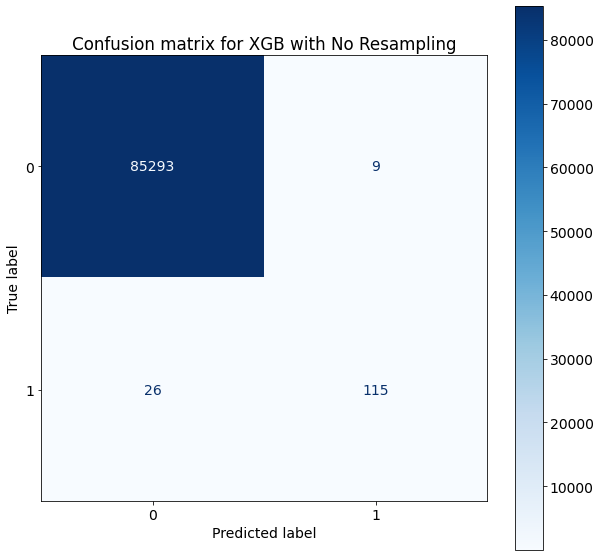

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Confusion matrix for XGB with No Resampling")
plot_confusion_matrix(xgb, X_test, y_test, cmap='Blues', ax=ax, values_format='d')

## P

In [ ]:
precision_LR_no_resampling_1 = round(precision_score(y_test, y_pred),5)
print(precision_LR_no_resampling_1)
precision_LR_no_resampling_0 = round(precision_score(y_test, y_pred, pos_label=0),5)
print(precision_LR_no_resampling_0)
precision_LR_no_resampling_avg = round(precision_score(y_test, y_pred, average='macro'),5)
print(precision_LR_no_resampling_avg)

0.92742
0.9997
0.96356


## R

In [ ]:
recall_LR_no_resampling_1 = round(recall_score(y_test, y_pred),5)
print(recall_LR_no_resampling_1)
recall_LR_no_resampling_0 = round(recall_score(y_test, y_pred, pos_label=0),5)
print(recall_LR_no_resampling_0)
recall_LR_no_resampling_avg = round(recall_score(y_test, y_pred, average='macro'),5)
print(recall_LR_no_resampling_avg)

0.8156
0.99989
0.90775


## F1

In [ ]:
f1_LR_no_resampling_1 = round(f1_score(y_test, y_pred),5)
print(f1_LR_no_resampling_1)
f1_LR_no_resampling_0 = round(f1_score(y_test, y_pred, pos_label=0),5)
print(f1_LR_no_resampling_0)
f1_LR_no_resampling_avg = round(f1_score(y_test, y_pred, average='macro'),5)
print(f1_LR_no_resampling_avg)

0.86792
0.99979
0.93386


In [ ]:
target_names = ['Class 0', 'Class 1']
print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

              precision    recall  f1-score   support

     Class 0    0.99970   0.99989   0.99979     85302
     Class 1    0.92742   0.81560   0.86792       141

    accuracy                        0.99959     85443
   macro avg    0.96356   0.90775   0.93386     85443
weighted avg    0.99958   0.99959   0.99958     85443



## PR

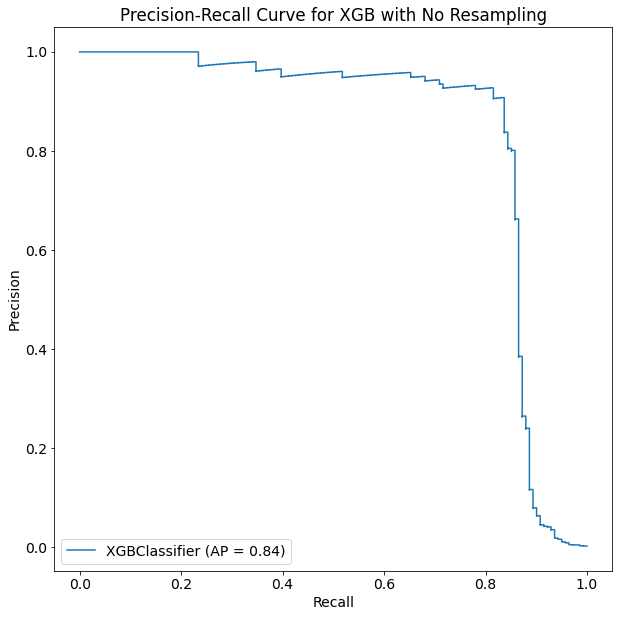

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Precision-Recall Curve for XGB with No Resampling')
plot_precision_recall_curve(xgb, X_test, y_test, ax=ax)

## ROC

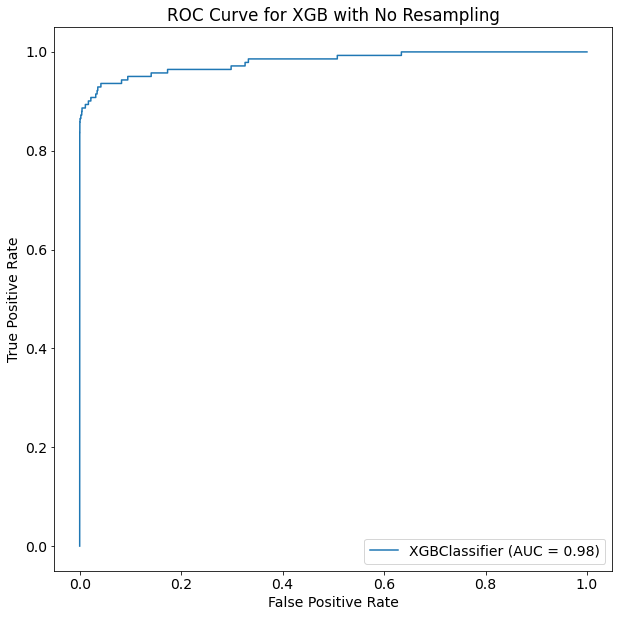

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('ROC Curve for XGB with No Resampling')
plot_roc_curve(xgb, X_test, y_test, ax=ax)

# XGBoost with Random Oversampling

## Hyperparameters Tuning

### Subsample and Colsample

In [ ]:
XGB_PARAM={'subsample':[0.5,0.6,0.7,0.8]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)

In [ ]:
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 21.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.18257418583505539,
                                              0.

In [ ]:
best_subsample = search.best_params_['subsample']
print(best_subsample) #0.8


0.8
0.18257418583505539


In [ ]:
XGB_PARAM={'colsample_bytree': [0.5,0.6,0.7,0.8,0.9]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0,subsample=0.8)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 29.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', re

In [ ]:
best_colsample = search.best_params_['colsample_bytree']
print(best_colsample) #0.8

0.8


### Max depth and alpha


In [ ]:
XGB_PARAM = {'max_depth':[3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.8, colsample_bytree=0.8)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 105.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=T

In [ ]:
best_depth = search.best_params_['max_depth']
print(best_depth) #10

10


In [ ]:
XGB_PARAM = {'alpha':[0,0.0001,0.001,0.1]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.8, colsample_bytree=0.8,max_depth=10)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 32.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1]

In [ ]:
best_alpha = search.best_params_['alpha']
print(best_alpha) #0

0


### Min child weight and gamma

In [ ]:
XGB_PARAM = {'min_child_weight':[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 73.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [1,

In [ ]:
best_child_weight = search.best_params_['min_child_weight']
print(best_child_weight) #1

1


In [ ]:
XGB_PARAM= {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 45.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 

In [ ]:
best_gamma = search.best_params_['gamma']
print(best_gamma) #0

0


### Estimators and learning rate

In [ ]:
XGB_PARAM = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 43.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.18257418583505539,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=10,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.000

In [ ]:
best_learning_rate = search.best_params_['learning_rate']
print(best_learning_rate) #0.3

0.3


In [ ]:
XGB_PARAM = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0,
                        learning_rate=0.3)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_over_7,np.ravel(y_over_7))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 375.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 520.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                    

In [ ]:
best_estimators = search.best_params_['n_estimators']
print(best_estimators) #1000

1000


# XGBoost with Random Undersampling

## Hyperparameters Tuning

### Subsample and Colsample

In [ ]:
XGB_PARAM={'subsample':[0.5,0.6,0.7,0.8]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'subsample': [0.5, 0.6, 0.7, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
best_subsample = search.best_params_['subsample']
print(best_subsample) #0.6

0.6


In [ ]:
XGB_PARAM={'colsample_bytree': [0.5,0.6,0.7,0.8,0.9]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0,subsample=0.6)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', re

In [ ]:
best_colsample = search.best_params_['colsample_bytree']
print(best_colsample) #0.6

0.6


### Max depth and alpha

In [ ]:
XGB_PARAM = {'max_depth':[3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.6s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=T

In [ ]:
best_depth = search.best_params_['max_depth']
print(best_depth) #6

6


In [ ]:
XGB_PARAM = {'alpha':[0,0.0001,0.001,0.1]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6,
                        max_depth=6)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, r

In [ ]:
best_alpha = search.best_params_['alpha']
print(best_alpha) #0

0


### Min child weight and gamma

In [ ]:
XGB_PARAM = {'min_child_weight':[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6,
                        max_depth=6,
                        alpha=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispat

In [ ]:
best_child_weight = search.best_params_['min_child_weight']
print(best_child_weight) #1

1


In [ ]:
XGB_PARAM= {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6,
                        max_depth=6,
                        alpha=0,
                        min_child_weight=1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.2s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs',

In [ ]:
best_gamma = search.best_params_['gamma']
print(best_gamma) #0

0


### Estimators and learning rate

In [ ]:
XGB_PARAM = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6,
                        max_depth=6,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   32.8s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                     

In [ ]:
best_estimator = search.best_params_['n_estimators']
print(best_estimator) #100

100


In [ ]:
XGB_PARAM = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6,
                        max_depth=6,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0,
                        n_estimators=100)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_under,np.ravel(y_under))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.6, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.6, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             pre_disp

In [ ]:
best_learning_rate = search.best_params_['learning_rate']
print(best_learning_rate) #0.2

0.2


### Final param

Params: subsample = 0.6, colsample = 0.6, max_depth = 6, alpha = 0, min_child_weight=1, gamma=0, n_estimators=100, learning_rate=0.2

In [ ]:
xgb_under = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.6,
                        colsample_bytree=0.6,
                        max_depth=6,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0,
                        n_estimators=100,
                        learning_rate=0.2)
xgb_under.fit(X_under,y_under)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, use_label_encoder=False, verbosity=0)

In [ ]:
y_pred_under = xgb_under.predict(X_test.values)

## CFS Matrix

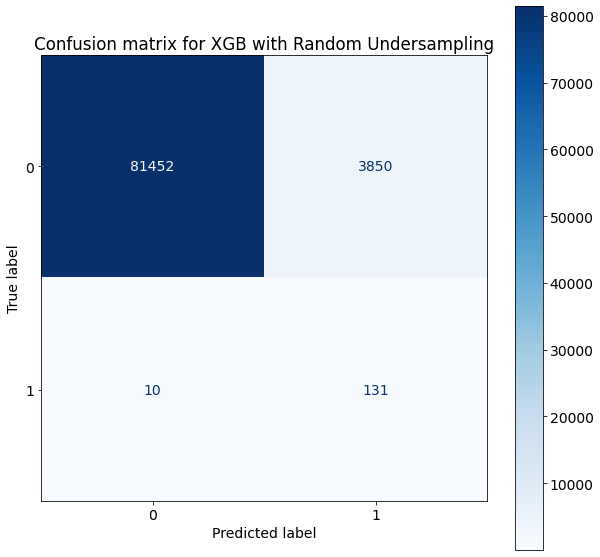

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Confusion matrix for XGB with Random Undersampling")
plot_confusion_matrix(xgb_under, X_test.values, y_test.values, cmap='Blues', ax=ax, values_format='d')

## P

In [ ]:
precision_XGB_under_1 = round(precision_score(y_test, y_pred_under),5)
print(precision_XGB_under_1)
precision_XGB_under_0 = round(precision_score(y_test, y_pred_under, pos_label=0),5)
print(precision_XGB_under_0)
precision_XGB_under_avg = round(precision_score(y_test, y_pred_under, average='macro'),5)
print(precision_XGB_under_avg)

0.03291
0.99988
0.51639


## R

In [ ]:
recall_XGB_under_1 = round(recall_score(y_test, y_pred_under),5)
print(recall_XGB_under_1)
recall_XGB_under_0 = round(recall_score(y_test, y_pred_under, pos_label=0),5)
print(recall_XGB_under_0)
recall_XGB_under_avg = round(recall_score(y_test, y_pred_under, average='macro'),5)
print(recall_XGB_under_avg)

0.92908
0.95487
0.94197


## F1

In [ ]:
f1_XGB_under_1 = round(f1_score(y_test, y_pred_under),5)
print(f1_XGB_under_1)
f1_XGB_under_0 = round(f1_score(y_test, y_pred_under, pos_label=0),5)
print(f1_XGB_under_0)
f1_XGB_under_avg = round(f1_score(y_test, y_pred_under, average='macro'),5)
print(f1_XGB_under_avg)

0.06356
0.97685
0.52021


In [ ]:
target_names = ['Class 0', 'Class 1']
print(classification_report(y_test, y_pred_under, target_names=target_names, digits=5))

              precision    recall  f1-score   support

     Class 0    0.99988   0.95487   0.97685     85302
     Class 1    0.03291   0.92908   0.06356       141

    accuracy                        0.95482     85443
   macro avg    0.51639   0.94197   0.52021     85443
weighted avg    0.99828   0.95482   0.97535     85443



## PR

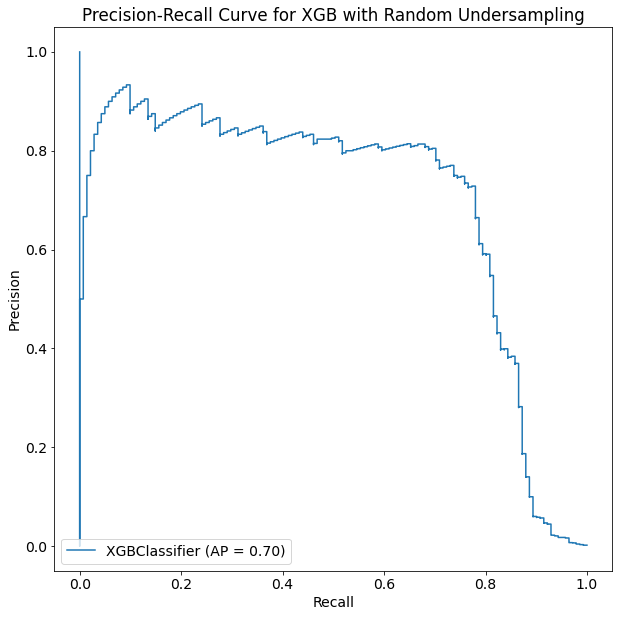

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Precision-Recall Curve for XGB with Random Undersampling')
plot_precision_recall_curve(xgb_under, X_test.values, y_test.values, ax=ax)

## ROC

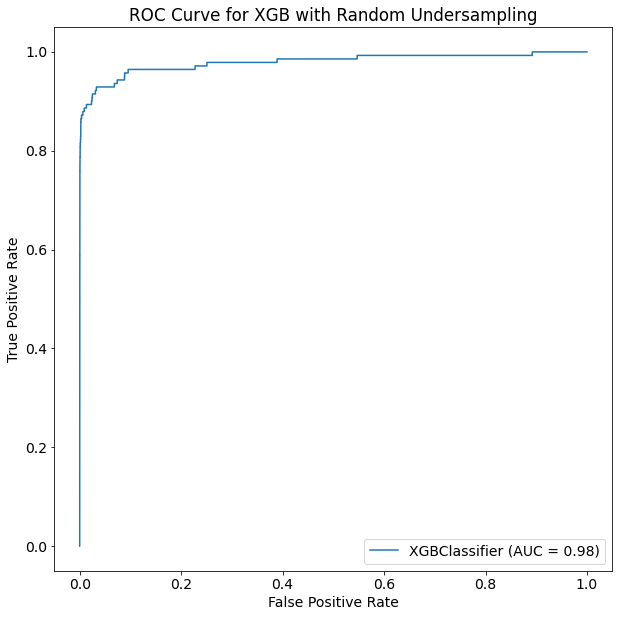

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('ROC Curve for XGB with Random Undersampling')
plot_roc_curve(xgb_under, X_test.values, y_test.values, ax=ax)

# XGBoost with SMOTE [NOT DONE]

## Hyperparameters Tuning

### Subsample and Colsample

In [ ]:
XGB_PARAM={'subsample':[0.5,0.6,0.7,0.8]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)

In [ ]:
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 39.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'subsample': [0.5, 0.6, 0.7, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
best_subsample = search.best_params_['subsample']
print(best_subsample) #0.7

0.7


In [ ]:
XGB_PARAM={'colsample_bytree': [0.5,0.6,0.7,0.8,0.9]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0,subsample=0.7)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 37.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', re

In [ ]:
best_colsample = search.best_params_['colsample_bytree']
print(best_colsample) #0.9

0.9


### Max depth and alpha


In [ ]:
XGB_PARAM = {'max_depth':[3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.7, colsample_bytree=0.9)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 161.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=T

In [ ]:
best_depth = search.best_params_['max_depth']
print(best_depth) #10

10


In [ ]:
XGB_PARAM = {'alpha':[0,0.0001,0.001,0.1]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.7, colsample_bytree=0.9,max_depth=10)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 79.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 113.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, 

In [ ]:
best_alpha = search.best_params_['alpha']
print(best_alpha) #0

0


### Min child weight and gamma

In [ ]:
XGB_PARAM = {'min_child_weight':[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.7, 
                        colsample_bytree=0.9,
                        max_depth=10,
                        alpha=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
best_child_weight = search.best_params_['min_child_weight']
print(best_child_weight) #1

In [ ]:
XGB_PARAM= {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.7, 
                        colsample_bytree=0.9,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 83.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 178.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs'

In [ ]:
best_gamma = search.best_params_['gamma']
print(best_gamma) #0.1

0.1


### Estimators and learning rate

In [ ]:
XGB_PARAM = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.7,
                        colsample_bytree=0.9,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0.1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 95.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 183.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             pre_d

In [ ]:
best_learning_rate = search.best_params_['learning_rate']
print(best_learning_rate) #0.3

0.3


**NEED TUNE ESTIMATOR**

In [12]:
XGB_PARAM = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]}

In [13]:
clf = xgb.XGBClassifier(use_label_encoder=False,
                        n_jobs=-1,
                        verbosity=0, 
                        subsample=0.7,
                        colsample_bytree=0.9,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0.1,
                        learning_rate=0.3)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_smote_7,np.ravel(y_smote_7))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(alpha=0, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0.1,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.7,
                                     tree_method=None, 

In [14]:
best_estimators = search.best_params_['n_estimators']
print(best_estimators) #300

300


# XGBoost with Tomek Links Removal [NOT DONE]


## Hyperamaters Tuning

### Subsample and Colsample

In [ ]:
XGB_PARAM={'subsample':[0.5,0.6,0.7,0.8]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)

In [ ]:
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 22.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'subsample': [0.5, 0.6, 0.7, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
best_subsample = search.best_params_['subsample']
print(best_subsample) #0.7

0.7


In [ ]:
XGB_PARAM={'colsample_bytree': [0.5,0.6,0.7,0.8,0.9]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0,subsample=0.7)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 10.6min


In [ ]:
best_colsample = search.best_params_['colsample_bytree']
print(best_colsample) #0.5

0.5


### Max depth and alpha


In [ ]:
XGB_PARAM = {'max_depth':[3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.7, colsample_bytree=0.5)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 42.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=T

In [ ]:
best_depth = search.best_params_['max_depth']
print(best_depth) #5

5


In [ ]:
XGB_PARAM = {'alpha':[0,0.0001,0.001,0.1]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0, subsample=0.7, colsample_bytree=0.5,max_depth=5)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 19.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, r

In [ ]:
best_alpha = search.best_params_['alpha']
print(best_alpha) #0

0


### Min child weight and gamma

In [ ]:
XGB_PARAM = {'min_child_weight':[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0, 
                        subsample=0.7, 
                        colsample_bytree=0.5,
                        max_depth=5,
                        alpha=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 42.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispat

In [ ]:
best_child_weight = search.best_params_['min_child_weight']
print(best_child_weight) #1

1


In [ ]:
XGB_PARAM= {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.7,
                        colsample_bytree=0.5,
                        max_depth=5,
                        alpha=0,
                        min_child_weight=1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 28.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs',

In [ ]:
best_gamma = search.best_params_['gamma']
print(best_gamma) #0.2

0.2


### Estimators and learning rate

In [ ]:
XGB_PARAM = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.7,
                        colsample_bytree=0.5,
                        max_depth=5,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0.2)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 26.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             pre_di

In [ ]:
best_learning_rate = search.best_params_['learning_rate']
print(best_learning_rate) #0.1

0.1


**NEED TUNE ESTIMATOR**

In [10]:
XGB_PARAM = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]}

In [11]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.7,
                        colsample_bytree=0.5,
                        max_depth=5,
                        alpha=0,
                        min_child_weight = 1,
                        gamma=0.2,
                        learning_rate=0.1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_tomek,np.ravel(y_tomek))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(alpha=0, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=0.2,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.7,
                                     tree_method=None, u

In [12]:
best_estimators = search.best_params_['n_estimators']
print(best_estimators) #700

700


# XGBoost with Hybrid Resampling

## Hyperparameters Tuning

### Subsample and Colsample

In [ ]:
XGB_PARAM={'subsample':[0.5,0.6,0.7,0.8]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_jobs=-1, verbosity=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 26.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 39.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'subsample': [0.5, 0.6, 0.7, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, retu

In [ ]:
best_subsample = search.best_params_['subsample']
print(best_subsample) #0.5

0.5


In [ ]:
XGB_PARAM={'colsample_bytree': [0.5,0.6,0.7,0.8,0.9]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 34.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', re

In [ ]:
best_colsample = search.best_params_['colsample_bytree']
print(best_colsample) #0.8

0.8


### Max depth and alpha

In [ ]:
XGB_PARAM = {'max_depth':[3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5,
                        colsample_bytree=0.8)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 132.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=T

In [ ]:
best_depth = search.best_params_['max_depth']
print(best_depth) #10

10


In [ ]:
XGB_PARAM = {'alpha':[0,0.0001,0.001,0.1]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        max_depth=10)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 94.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, 

In [ ]:
best_alpha = search.best_params_['alpha']
print(best_alpha) #0

0


### Min child weight and gamma

In [ ]:
XGB_PARAM = {'min_child_weight':[1,2,3,4,5,6,7,8,9,10]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 65.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 216.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispa

In [ ]:
best_child_weight = search.best_params_['min_child_weight']
print(best_child_weight) #1

1


In [ ]:
XGB_PARAM= {'gamma':[0,0.1,0.2,0.3,0.4,0.5]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 139.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs'

In [ ]:
best_gamma = search.best_params_['gamma']
print(best_gamma) #0.2

0.2


### Estimators and learning rate


In [ ]:
XGB_PARAM = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

In [ ]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0.2)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 77.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 142.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.2,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, use_label_encoder=False,
                                     verbosity=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]},
             pre_d

In [ ]:
best_learning_rate = search.best_params_['learning_rate']
print(best_learning_rate) #0.3

0.3


In [17]:
XGB_PARAM = {'n_estimators':[50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]}

In [18]:
clf = xgb.XGBClassifier(use_label_encoder=False, 
                        n_jobs=-1, 
                        verbosity=0,
                        subsample=0.5,
                        colsample_bytree=0.8,
                        max_depth=10,
                        alpha=0,
                        min_child_weight=1,
                        gamma=0.2,
                        learning_rate=0.3)
search = GridSearchCV(clf, XGB_PARAM, cv=10, verbose=3, n_jobs=-1)
search.fit(X_hybrid,np.ravel(y_hybrid))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(alpha=0, base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.2,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.3, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.5,
                                     tree_method=None, 

In [19]:
est_estimators = search.best_params_['n_estimators']
print(best_estimators) #700

700
